#### **Welcome to Assignment 2**
This assignment consists of three parts. Part-1 is based on the content you learned in Week-3 of course and Part-2 is based on the content you learned in Week-4 of the course. Part-3 is **un-graded** and mainly designed to help you flex the Deep Learning muscles grown in Part-2. 

Unlike the first two parts, you'll have to implement everything from scratch in Part-3. If you find answers to questions in Part-3, feel free to head out to the forums and discuss them with your classmates!

#### **Instructions**
1. Use Python 3.x to run this notebook
2. Write your code only in between the lines 'YOUR CODE STARTS HERE' and 'YOUR CODE ENDS HERE'.
you should not change anything else in the code cells, if you do, the answers you are supposed to get at the end of this assignment might be wrong.
3. Read documentation of each function carefully.
4. All the Best!

# Part-1

In [104]:
# Imports
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

# %matplotlib inline uncomment this line if you're running this notebook on your local PC

In [105]:
# DO NOT CHANGE THIS CODE
np.random.seed(10)

### Question 1 : Line detection from a given image.


Find the starting and ending point co-ordinates of detected lines of a given image (line.png) using hough transform.

Following criterion need to be satisfied to qualify as a line:

(a) Minimum line length = 60;
(b) Maximum allowed gap between line segments = 250;
(c) Accumulator threshold parameter = 15  (only those lines are returned that get enough votes);
(d) Distance resolution of the accumulator in pixels = 1;
(e) Angle resolution of the accumulator in radians = pi/180



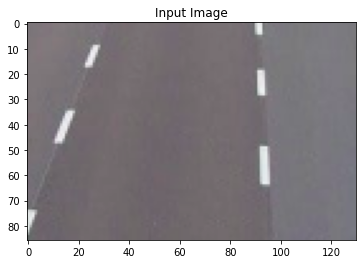

Line 0 starting point is (0, 83) and ending point is (25, 9)
Line 1 starting point is (92, 0) and ending point is (95, 64)
Line 2 starting point is (1, 81) and ending point is (27, 9)
Line 3 starting point is (90, 0) and ending point is (92, 63)


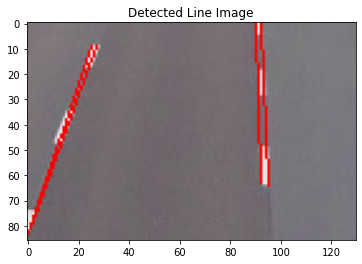

In [106]:
#Read image 
img = cv2.imread('line.png', cv2.IMREAD_COLOR)

# Visualize the input image
plt.imshow(img)
plt.title('Input Image')
plt.show()

#### YOUR CODE STARTS HERE #####
#convert the image to gray-scale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#### YOUR CODE ENDS HERE #####

#Find the edges in the image using canny detector

edges = cv2.Canny(gray, 50, 200)

#### YOUR CODE STARTS HERE #####
# params - edges, distance resolution, angle resoulution, accumulator threshold, minimum line length, maximum allowed gap 
detected_lines = cv2.HoughLinesP(edges, 1, np.pi/180, 15, minLineLength = 60, maxLineGap = 250)
    
for i in range(len(detected_lines)):
    for x1, y1, x2, y2 in detected_lines[i]:
        print(f'Line {i} starting point is ({x1}, {y1}) and ending point is ({x2}, {y2})')
        cv2.line(img, (x1, y1), (x2, y2), (255, 0, 0), 1)

#### YOUR CODE ENDS HERE #####
plt.imshow(img)
plt.title('Detected Line Image')
plt.show()

##Question 2: Point matching using RANSAC

Given two sets of points related by affine transformation(with an outlier rate), use the RANSAC method to estimate the Affine transformation parameters between them and the number of inliers(Matching points).

What is the estimated number of inliers for an outlier rate of 0.9?


In [107]:
import numpy as np
np.random.seed(0)


# Affine Transformation
# |x'|  = |a, b| * |x|  +  |tx|
# |y'|    |c, d|   |y|     |ty|
# points_t =    A   * points_s  + t

# -------------------------------------------------------------

class Transform():

    def create_case(self, out_rate):
        ''' CREATE_CASE

            Method to generate a test case for affine transformation

            Input arguments:
            - out_rate : the percentage of outliers in test case

            Outputs:
            - points_s : Source points that will be transformed
            - points_t : warped points
            - A, t : parameters of affine transformation, A is a 2x2
            matrix, t is a 2x1 vector, both of them are created randomly

        '''


        # Generate an affine transformation
        # A is a 2x2 matrix, with values in range -2 to 2
        A = 4 * np.random.rand(2, 2) - 2

        # t is a 2x1 vector, with values in range -10 to 10
        t = 20 * np.random.rand(2, 1) - 10

        # Set the num_points = 1000 for the test case
        num_points = 1000

        #### YOUR CODE STARTS HERE ####
        # Compute the no. of outliers and the no. of inliers respectively
        outliers = int(out_rate * num_points)
        inliers = int(num_points - outliers)
        assert(inliers + outliers == num_points)
        #### YOUR CODE ENDS HERE ####

        # Gernerate source points, with scope from (0,0) to (100, 100)
        points_s = 100 * np.random.rand(2, num_points)

        # Initialization of the warped points matrix
        points_t = np.zeros((2, num_points))

        #### YOUR CODE STARTS HERE ####
        # Compute inliers in warped points matrix by applying A and t
        points_t[:, :inliers] = np.matmul(A, points_s[:, :inliers]) + t
        #### YOUR CODE ENDS HERE ####

        # Outliers in warped points matrix
        points_t[:, inliers:] = 100 * np.random.rand(2, outliers)

        # Reset the order of warped points matrix
        # outliers and inliers will scatter randomly in test case
        rand_inx = np.random.permutation(num_points)
        points_s = points_s[:, rand_inx]
        points_t = points_t[:, rand_inx]

        return A, t, points_s, points_t

    def affine_transformation(self, points_s, points_t):  
        ''' AFFINE_TRANSFORMATION

            Perform affine transformation

            Input arguments:
            - points_t : points in target image
            - points_s : points in source image

            Outputs:

            - A, t : the affine transformation, A is a 2x2 matrix
            that indicates the rotation and scaling transformation,
            t is a 2x1 vector determines the translation

            Method:

            To estimate an affine transformation between two images,
            at least 3 corresponding points are needed.
            In this case, 6-parameter affine transformation are taken into
            consideration, which is shown as follows:

            | x' | = | a b | * | x | + | tx |
            | y' |   | c d |   | y |   | ty |

            For 3 corresponding points, 6 equations can be formed as below:

            | x1 y1 0  0  1 0 |       | a  |       | x1' |
            | 0  0  x1 y1 0 1 |       | b  |       | y1' |
            | x2 y2 0  0  1 0 |   *   | c  |   =   | x2' |
            | 0  0  x2 y2 0 1 |       | d  |       | y2' |
            | x3 y3 0  0  1 0 |       | tx |       | x3' |
            | 0  0  x3 y3 0 1 |       | ty |       | y3' |

            |------> M <------|   |-> theta <-|   |-> b <-|

            Solve the equation by calculating:  theta = M \ b
            Thus, affine transformation can be obtained as:

            A = | a b |     t = | tx |
                | c d |         | ty |

        '''

        #### YOUR CODE STARTS HERE ####
        #print(points_s)
        M = np.zeros((6, 6))
        
        # M matrix construction
        for i in range(0, 5, 2):
            x1 = points_s[0][i//2]
            y1 = points_s[1][i//2]
            M[i][0] = x1
            M[i][1] = y1
            M[i][4] = 1
            M[i+1][2] = x1
            M[i+1][3] = y1
            M[i+1][5] = 1
            
        
        x1_ = points_t[0][0]
        y1_ = points_t[1][0]
        x2_ = points_t[0][1]
        y2_ = points_t[1][1]
        x3_ = points_t[0][2]
        y3_ = points_t[1][2]
        
        b = np.array([x1_, y1_, x2_, y2_, x3_, y3_])
        assert(b.shape == (6, 1))
        
        theta = np.matmul(np.linalg.inv(M), b)
        assert(theta.shape == (6, 1))
        
        A = np.zeros((2, 2))
        A[0][0] = theta[0]
        A[0][1] = theta[1]
        A[1][0] = theta[2]
        A[1][1] = theta[3]
        assert(A.shape == (2, 2))
        
        t = np.array([theta[4], theta[5]])
        assert(t.shape == (2,1))
        
        return A, t

        #### YOUR CODE ENDS HERE ####
# -------------------------------------------------------------

# Create instance
tf = Transform()

# Generate a test case as validation with
# a rate of outliers
out_rate = 0.90
A_true, t_true, points_s, points_t = tf.create_case(out_rate)
print(len(points_s))

# At least 3 corresponding points to
# estimate affine transformation
L = 3
# Randomly select 3 pairs of points to do estimation
idx = np.random.randint(0, points_s.shape[1], (L, 1))

A_test, t_test = tf.affine_transformation(points_s[:, idx], points_t[:, idx])

# -------------------------------------------------------------
# Test Class RansacClass
# The number of iterations in RANSAC
ITER_NUM = 2000


class RansacClass():

    def __init__(self, L=3, thr=1): 
        ''' __INIT__

            Initialize the instance.

            Input arguments:

            - L : the number of corresponding points,
            default is 3
            - thr : threshold that determines which points are inliers
            by comparing residual with it

        '''

        self.L = L
        self.thr = thr

    def calculate_distance(self, A, t, points_s, points_t):     
        ''' CALCULATE_DISTANCE

            Compute residual length between estimation and 
            real target points.
 

            Input arguments:

            - A, t : the estimated affine transformation
                     (using least square)
            - points_s : key points taken from source image
            - points_t : key points taken from target image

            Output:

            - residual : Euclidean distance between target 
            points and estimated points. Euclidean distance is
            nothing but the residual length

        '''

        ###YOUR CODE START HERE
        assert(A.shape == (2, 2))
        
        estimated_points_t = np.matmul(A, points_s) + t
        
        # calculating euclidean distance between each point of points_s and points_t
        residual = np.sqrt(np.sum((estimated_points_t - points_t)**2, axis=0))

        return residual
    
        ###YOUR CODE ENDS HERE

    def apply_ransac(self, points_s, points_t):
        ''' APPLY_RANSAC

            Use this method to get the estimated affine 
            transformation, also inliers.

            Input arguments:

            - points_s : key points from source image
            - points_t : key points from target image

            Output:

            - A, t : estimated affine transformation
            - inliers : indices of inliers 

        '''
        #### YOUR CODE START HERE
        
        # optimal A matrix
        best_A = None
        # optimal t vector
        best_t = None

        # list containing indices of inliers obtained by optimal transformation parameters
        best_inliers_idx = None
        # inliers count
        best_inliers_count = 0
        
        for i in range(ITER_NUM):
            
            # Randomly select 3 pairs of points to do estimation
            idx = []
            # repeat until all three indices are different i.e. all three distinct points are chosen
            # to avoid singular matrix error
            while len(idx) == 0 or (idx[0] == idx[1] or idx[1] == idx[2] or idx[2] == idx[0]):
                idx = np.random.randint(0, points_s.shape[1], (self.L, 1))
                
            # idx = np.random.randint(0, points_s.shape[1], (self.L, 1))
            
            # transform the points_s by obtained A, t parameters
            A_cur, t_cur = tf.affine_transformation(points_s[:, idx], points_t[:, idx])

            residual = self.calculate_distance(A_cur, t_cur, points_s, points_t)

            inliers_cur_idx = []
            for i in range(points_s.shape[1]):
                # appending those points whose residual length is less than threshold
                if residual[i] < self.thr:
                    inliers_cur_idx.append(i)
            
            inliers_cur_count = len(inliers_cur_idx)
            
            # updating global inliers_count and A, t params if better params are obtained
            if inliers_cur_count > best_inliers_count:
                best_inliers_count = inliers_cur_count
                best_A = A_cur
                best_t = t_cur
                best_inliers_idx = inliers_cur_idx
        
        best_inliers_idx = [best_inliers_idx]
        best_inliers_idx = np.array(np.array(best_inliers_idx))

        return best_A, best_t, best_inliers_idx
        #### YOUR CODE ENDS HERE
# -------------------------------------------------------------

# Create instance
rs = RansacClass(L=3, thr=1)

#residual = rs.calculate_distance(A_test, t_test, points_s, points_t)
A_rsc, t_rsc, inliers = rs.apply_ransac(points_s, points_t)

# print the number of inliners or point matches
print(inliers[0].shape)

2
(101,)


101 inliers are estimated using the above ransac algorithm

### Question 3: Detect corners in a given image using Harris Corner Detection Algorithm

Find the number of detected corner points in a given image (line.png) using Harris Corner Detection Algorithm. Note that, Following criterion MUST be satisfied while applying Harris Corner detection Algorithm:

(a)  The size of neighbourhood considered for corner detection = 2.
(b)  Aperture parameter of Sobel derivative used = 3.
(c)  Harris detector free parameter in the equation = 0.04.

How many corners are detected?



222 corners are detected


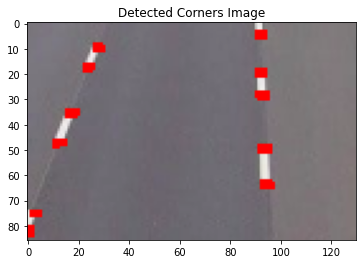

In [108]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

%matplotlib inline

# Read in the image
image = cv2.imread('line.png')

# Make a copy of the image
image_copy = np.copy(image)

# Change color to RGB (from BGR)
image_copy = cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)

###YOUR CODE STARTS HERE

## STEP 1:  Convert to grayscale 
gray = cv2.cvtColor(image_copy, cv2.COLOR_BGR2GRAY)

## STEP 2: Detect corners 
# params - image, window size, aperture parameter of sobel derivative, harris detector free parameter
corners = cv2.cornerHarris(gray, 2, 3, 0.04)

## STEP 3: Dilate corner image to enhance corner points
dilated_corner_img = cv2.dilate(corners, None)

## STEP 4:set threshold value as 0.1 * (maximum value of dilated corner image obtained from STEP3)
threshold = 0.1 * dilated_corner_img.max()

## STEP 5: Count numer of detected corner points and draw them on the image
detected_corners_count = 0
for i in range(dilated_corner_img.shape[0]):
    for j in range(dilated_corner_img.shape[1]):
        if dilated_corner_img[i][j] > threshold:
            detected_corners_count += 1
            image_copy[i][j] = [255, 0, 0]

print(f'{detected_corners_count} corners are detected')

plt.imshow(image_copy)
plt.title('Detected Corners Image')
plt.show()
    
### YOUR CODE ENDS HERE

# Part-2

In this section, we will train a neural network to learn to identify numerals from [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. Fill out the missing pieces in each of the following cells. 

In [109]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F
import timeit
import unittest

## Please DONOT remove these lines. 
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

### Data Loading and Pre-processing

In [110]:
# print(torch.cuda.is_available())
# print(torch.cuda.current_device())
# print(torch.cuda.get_device_name())

In [111]:
# check availability of GPU and set the device accordingly
#### YOUR CODE STARTS HERE ####
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define a transforms for preparing the dataset
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=0.1307, std=0.3081)])

# convert the image to a pytorch tensor
# normalise the images with mean (0.1307) and std (0.3081) of the dataset
#### YOUR CODE ENDS HERE ####

In [112]:
# Load the MNIST training, test datasets using `torchvision.datasets.MNIST` using the transform defined above
#### YOUR CODE STARTS HERE ####
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
#### YOUR CODE ENDS HERE ####

In [113]:
# import os 
# print(os.cpu_count())

In [114]:
# create dataloaders for training and test datasets
# use a batch size of 32 and set shuffle=True for the training set
#### YOUR CODE STARTS HERE ####
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True, num_workers = 2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle = True, num_workers = 2)
#### YOUR CODE ENDS HERE ####

In [115]:
# print(train_dataset.data.shape)
# print(test_dataset.data.shape)

In [116]:
# print(train_dataset.classes)

### Network Definition

In [117]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        #### YOUR CODE STARTS HERE ####
        # define a conv layer with output channels as 16, kernel size of 3 and stride of 1
        self.conv1 = nn.Conv2d(1, 16, 3, stride=1)
        # define a conv layer with output channels as 32, kernel size of 3 and stride of 1
        self.conv2 = nn.Conv2d(16, 32, 3, stride=1)
        # define a conv layer with output channels as 64, kernel size of 3 and stride of 1
        self.conv3 = nn.Conv2d(32, 64, 3, stride=1)
        # define a max pooling layer with kernel size 2
        self.pool = nn.MaxPool2d(2)
        # define dropout layer with a probability of 0.25
        self.dropout = nn.Dropout2d(p=0.25)
        # define dropout layer with a probability of 0.5
        self.dropout1 = nn.Dropout2d(p=0.5)
        # define a linear(dense) layer with 128 output features
        self.fc1 = nn.Linear(64*11*11, 128)
        # define a linear(dense) layer with output features corresponding to the number of classes in the dataset
        self.fc2 = nn.Linear(128, 10)

        #### YOUR CODE ENDS HERE ####

    def forward(self, x):
        # Use the layers defined above in a sequential way (folow the same as the layer definitions above) and 
        # write the forward pass, after each of conv1, conv2, conv3 and fc1 use a relu activation. 
        # use the first dropout after maxpool and the other one before you final FC layer
        #### YOUR CODE STARTS HERE ####
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = self.dropout(self.pool(F.relu(self.conv3(out))))
        out = torch.flatten(out, 1)
        out = F.relu(self.fc1(out))
        out = self.fc2(self.dropout1(out))
        #### YOUR CODE ENDS HERE ####
        output = F.log_softmax(out, dim=1)
        return output

### Sanity Check
Make sure all the tests below pass without any errors, before you proceed with the training part.

In [118]:
import unittest

class TestImplementations(unittest.TestCase):
    
    # Dataloading tests
    def test_dataset(self):
        self.dataset_classes = ['0 - zero',
                                '1 - one',
                                '2 - two',
                                '3 - three',
                                '4 - four',
                                '5 - five',
                                '6 - six',
                                '7 - seven',
                                '8 - eight',
                                '9 - nine']
        self.assertTrue(train_dataset.classes == self.dataset_classes)
        self.assertTrue(train_dataset.train == True)
    
    def test_dataloader(self):        
        self.assertTrue(train_dataloader.batch_size == 32)
        self.assertTrue(test_dataloader.batch_size == 32)      
         
    def test_total_parameters(self):
        model = Net().to(device)
        self.assertTrue(sum(p.numel() for p in model.parameters()) == 1015946)

suite = unittest.TestLoader().loadTestsFromModule(TestImplementations())
unittest.TextTestRunner().run(suite)

...
----------------------------------------------------------------------
Ran 3 tests in 0.016s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

### Training and Inference

In [119]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    epoch_loss = []
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
      #### YOUR CODE STARTS HERE ####
        # send the image, target to the device
        data = data.to(device)
        target = target.to(device)
        
        # flush out the gradients stored in optimizer
        optimizer.zero_grad()
        
        # pass the image to the model and assign the output to variable named output
        output = model(data)
        
        # calculate the loss (use nll_loss in pytorch)
        loss = F.nll_loss(output, target)
        
        # do a backward pass
        loss.backward()
        
        epoch_loss.append(loss.item())

        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        # update the weights
        optimizer.step()
        
      #### YOUR CODE ENDS HERE ####
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
    train_accuracy = 100. * correct / len(train_loader.dataset)
            
    return (sum(epoch_loss)/len(epoch_loss), train_accuracy)

In [120]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
          ### YOUR CODE STARTS HERE ####
            # send the image, target to the device
            data = data.to(device)
            target = target.to(device)
            
            # pass the image to the model and assign the output to variable named output
            output = model(data)
            
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            
          #### YOUR CODE ENDS HERE ####
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_accuracy = 100. * correct / len(test_loader.dataset)

    return (test_loss, test_accuracy)

### Question 4

Use Adam as the optimiser and train the model for 25 epochs. Report the train, test loss and accuracies along with the total time taken for training. (Use plots if required)

In [121]:
import time

In [122]:
start_time = time.time()

model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
train_loss_values = []
test_loss_values = []
train_accuracy_values = []
test_accuracy_values = []
for epoch in range(25):
    train_loss, train_accuracy = train(model, device, train_dataloader, optimizer, epoch)
    train_loss_values.append(train_loss)
    train_accuracy_values.append(train_accuracy)
    
    test_loss, test_accuracy = test(model, device, test_dataloader)
    test_loss_values.append(test_loss)
    test_accuracy_values.append(test_accuracy)

end_time = time.time()
print(end_time-start_time)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.304365
Train Epoch: 0 [640/60000 (1%)]	Loss: 1.874691
Train Epoch: 0 [1280/60000 (2%)]	Loss: 1.049681
Train Epoch: 0 [1920/60000 (3%)]	Loss: 0.976689
Train Epoch: 0 [2560/60000 (4%)]	Loss: 0.630705
Train Epoch: 0 [3200/60000 (5%)]	Loss: 0.469894
Train Epoch: 0 [3840/60000 (6%)]	Loss: 0.691195
Train Epoch: 0 [4480/60000 (7%)]	Loss: 0.486567
Train Epoch: 0 [5120/60000 (9%)]	Loss: 0.641696
Train Epoch: 0 [5760/60000 (10%)]	Loss: 0.571212
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.896605
Train Epoch: 0 [7040/60000 (12%)]	Loss: 0.288362
Train Epoch: 0 [7680/60000 (13%)]	Loss: 0.271304
Train Epoch: 0 [8320/60000 (14%)]	Loss: 0.423987
Train Epoch: 0 [8960/60000 (15%)]	Loss: 0.410250
Train Epoch: 0 [9600/60000 (16%)]	Loss: 1.137544
Train Epoch: 0 [10240/60000 (17%)]	Loss: 0.607373
Train Epoch: 0 [10880/60000 (18%)]	Loss: 0.433468
Train Epoch: 0 [11520/60000 (19%)]	Loss: 0.782657
Train Epoch: 0 [12160/60000 (20%)]	Loss: 0.327005
Train Epoch: 0 [12800/60000 (

Text(0.5, 1.0, 'Training loss vs Number of epochs')

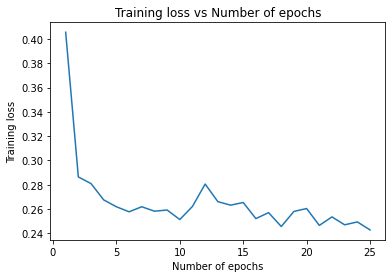

In [123]:
plt.plot(np.linspace(1, 25, 25).astype(int), train_loss_values)
plt.xlabel('Number of epochs')
plt.ylabel('Training loss')
plt.title('Training loss vs Number of epochs')

Text(0.5, 1.0, 'Training accuracy vs Number of epochs')

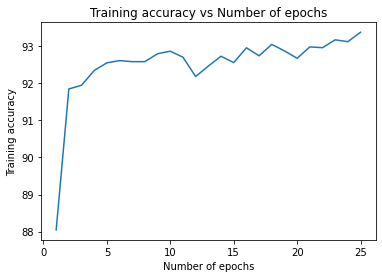

In [124]:
plt.plot(np.linspace(1, 25, 25).astype(int), train_accuracy_values)
plt.xlabel('Number of epochs')
plt.ylabel('Training accuracy')
plt.title('Training accuracy vs Number of epochs')

Text(0.5, 1.0, 'Test loss vs Number of epochs')

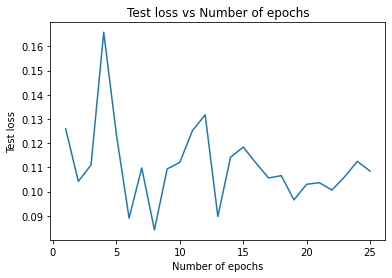

In [125]:
plt.plot(np.linspace(1, 25, 25).astype(int), test_loss_values)
plt.xlabel('Number of epochs')
plt.ylabel('Test loss')
plt.title('Test loss vs Number of epochs')

Text(0.5, 1.0, 'Test accuracy vs Number of epochs')

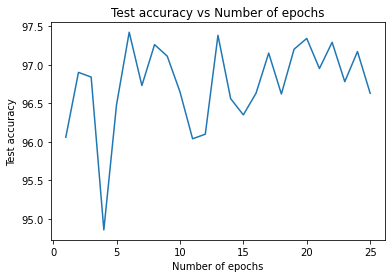

In [126]:
plt.plot(np.linspace(1, 25, 25).astype(int), test_accuracy_values)
plt.xlabel('Number of epochs')
plt.ylabel('Test accuracy')
plt.title('Test accuracy vs Number of epochs')

Time taken - 513.31 seconds <br/>
Train loss - 0.2400 <br/>
Test average loss - 0.1085 <br/> 
Test accuracy - 9663/10000 (97%) <br/>


### Question 5

Modify the network defined in the previous step to replace ReLU activations with Sigmoid and report the final test accuracy. Is there a drop in accuracy, what do you think is the reason? 

In [127]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        #### YOUR CODE STARTS HERE ####
        # define a conv layer with output channels as 16, kernel size of 3 and stride of 1
        self.conv1 = nn.Conv2d(1, 16, 3, stride=1)

        # define a conv layer with output channels as 32, kernel size of 3 and stride of 1
        self.conv2 = nn.Conv2d(16, 32, 3, stride=1)

        # define a conv layer with output channels as 64, kernel size of 3 and stride of 1
        self.conv3 = nn.Conv2d(32, 64, 3, stride=1)

        # define a max pooling layer with kernel size 2
        self.pool = nn.MaxPool2d(2)
        # define dropout layer with a probability of 0.25
        self.dropout = nn.Dropout2d(p=0.25)
        # define dropout layer with a probability of 0.5
        self.dropout1 = nn.Dropout2d(p=0.5)
        # define a linear(dense) layer with 128 output features
        self.fc1 = nn.Linear(64*11*11, 128)
        # define a linear(dense) layer with output features corresponding to the number of classes in the dataset
        self.fc2 = nn.Linear(128, 10)

        #### YOUR CODE ENDS HERE ####

    def forward(self, x):
        # Use the layers defined above in a sequential way (folow the same as the layer definitions above) and 
        # write the forward pass, after each of conv1, conv2, conv3 and fc1 use a relu activation. 
        # use the first dropout after maxpool and the other one before you final FC layer
        #### YOUR CODE STARTS HERE ####

        out = torch.sigmoid(self.conv1(x))
        out = torch.sigmoid(self.conv2(out))
        out = self.dropout(self.pool(torch.sigmoid(self.conv3(out))))
        out = torch.flatten(out, 1)
        out = torch.sigmoid(self.fc1(out))
        out = self.fc2(self.dropout1(out))

        #### YOUR CODE ENDS HERE ####
        output = F.log_softmax(out, dim=1)
        return output

In [128]:
start_time = time.time()

model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
train_loss_values = []
test_loss_values = []
train_accuracy_values = []
test_accuracy_values = []
for epoch in range(25):
    train_loss, train_accuracy = train(model, device, train_dataloader, optimizer, epoch)
    train_loss_values.append(train_loss)
    train_accuracy_values.append(train_accuracy)
    
    test_loss, test_accuracy = test(model, device, test_dataloader)
    test_loss_values.append(test_loss)
    test_accuracy_values.append(test_accuracy)

end_time = time.time()
print(end_time-start_time)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.532858
Train Epoch: 0 [640/60000 (1%)]	Loss: 2.355240
Train Epoch: 0 [1280/60000 (2%)]	Loss: 2.332285
Train Epoch: 0 [1920/60000 (3%)]	Loss: 2.429274
Train Epoch: 0 [2560/60000 (4%)]	Loss: 2.392992
Train Epoch: 0 [3200/60000 (5%)]	Loss: 2.365077
Train Epoch: 0 [3840/60000 (6%)]	Loss: 2.403429
Train Epoch: 0 [4480/60000 (7%)]	Loss: 2.281060
Train Epoch: 0 [5120/60000 (9%)]	Loss: 2.484349
Train Epoch: 0 [5760/60000 (10%)]	Loss: 2.257668
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.520397
Train Epoch: 0 [7040/60000 (12%)]	Loss: 2.416665
Train Epoch: 0 [7680/60000 (13%)]	Loss: 2.384464
Train Epoch: 0 [8320/60000 (14%)]	Loss: 2.390507
Train Epoch: 0 [8960/60000 (15%)]	Loss: 2.279351
Train Epoch: 0 [9600/60000 (16%)]	Loss: 2.379575
Train Epoch: 0 [10240/60000 (17%)]	Loss: 2.465402
Train Epoch: 0 [10880/60000 (18%)]	Loss: 2.336079
Train Epoch: 0 [11520/60000 (19%)]	Loss: 2.446063
Train Epoch: 0 [12160/60000 (20%)]	Loss: 2.399849
Train Epoch: 0 [12800/60000 (

Text(0.5, 1.0, 'Training loss vs Number of epochs')

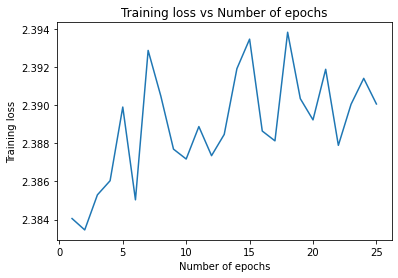

In [129]:
plt.plot(np.linspace(1, 25, 25).astype(int), train_loss_values)
plt.xlabel('Number of epochs')
plt.ylabel('Training loss')
plt.title('Training loss vs Number of epochs')

Text(0.5, 1.0, 'Training accuracy vs Number of epochs')

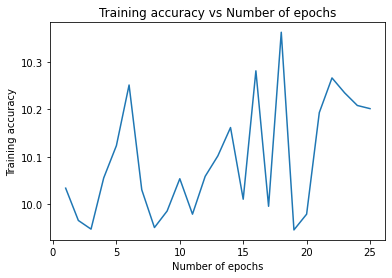

In [130]:
plt.plot(np.linspace(1, 25, 25).astype(int), train_accuracy_values)
plt.xlabel('Number of epochs')
plt.ylabel('Training accuracy')
plt.title('Training accuracy vs Number of epochs')

Text(0.5, 1.0, 'Test loss vs Number of epochs')

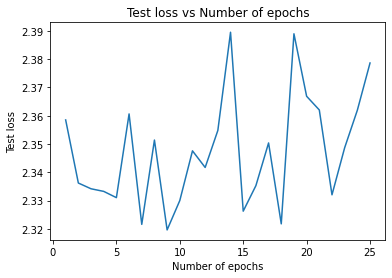

In [131]:
plt.plot(np.linspace(1, 25, 25).astype(int), test_loss_values)
plt.xlabel('Number of epochs')
plt.ylabel('Test loss')
plt.title('Test loss vs Number of epochs')

Text(0.5, 1.0, 'Test accuracy vs Number of epochs')

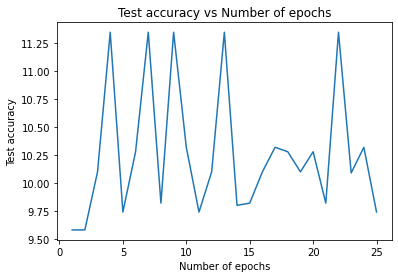

In [132]:
plt.plot(np.linspace(1, 25, 25).astype(int), test_accuracy_values)
plt.xlabel('Number of epochs')
plt.ylabel('Test accuracy')
plt.title('Test accuracy vs Number of epochs')

Time taken - 516.19 seconds <br/>
Train loss - 2.378 <br/>
Test average loss - 2.3786 <br/> 
Test accuracy - 974/10000 (10%) <br/>
Since sigmoid activation function has vanishing and exploding gradient problem and the inputs are large (no normalization) and hence gradients become too small, thus it doesn't converge in just 25 epochs and thus require large epochs. Hence accuracy drops down to just 10% as epochs are very less and gradients become very small. While ReLu overcomes this problem and hence in 25 epochs, it achieves fairly good accuracy.

### Question 6

Train the network defined in Question-1 with a different optimiser other than Adam, do you see any difference in performance? Substantiate your observations with relevant explanations.

In [133]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        #### YOUR CODE STARTS HERE ####
        # define a conv layer with output channels as 16, kernel size of 3 and stride of 1
        self.conv1 = nn.Conv2d(1, 16, 3, stride=1)

        # define a conv layer with output channels as 32, kernel size of 3 and stride of 1
        self.conv2 = nn.Conv2d(16, 32, 3, stride=1)

        # define a conv layer with output channels as 64, kernel size of 3 and stride of 1
        self.conv3 = nn.Conv2d(32, 64, 3, stride=1)

        # define a max pooling layer with kernel size 2
        self.pool = nn.MaxPool2d(2)
        # define dropout layer with a probability of 0.25
        self.dropout = nn.Dropout2d(p=0.25)
        # define dropout layer with a probability of 0.5
        self.dropout1 = nn.Dropout2d(p=0.5)
        # define a linear(dense) layer with 128 output features
        self.fc1 = nn.Linear(64*11*11, 128)
        # define a linear(dense) layer with output features corresponding to the number of classes in the dataset
        self.fc2 = nn.Linear(128, 10)

        #### YOUR CODE ENDS HERE ####

    def forward(self, x):
        # Use the layers defined above in a sequential way (folow the same as the layer definitions above) and 
        # write the forward pass, after each of conv1, conv2, conv3 and fc1 use a relu activation. 
        # use the first dropout after maxpool and the other one before you final FC layer
        #### YOUR CODE STARTS HERE ####
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = self.dropout(self.pool(F.relu(self.conv3(out))))
        out = torch.flatten(out, 1)
        out = F.relu(self.fc1(out))
        out = self.fc2(self.dropout1(out))
        #### YOUR CODE ENDS HERE ####
        output = F.log_softmax(out, dim=1)
        return output

In [134]:
start_time = time.time()

model = Net().to(device)
optimizer = optim.Adagrad(model.parameters(), lr=0.01)
train_loss_values = []
test_loss_values = []
train_accuracy_values = []
test_accuracy_values = []
for epoch in range(25):
    train_loss, train_accuracy = train(model, device, train_dataloader, optimizer, epoch)
    train_loss_values.append(train_loss)
    train_accuracy_values.append(train_accuracy)
    
    test_loss, test_accuracy = test(model, device, test_dataloader)
    test_loss_values.append(test_loss)
    test_accuracy_values.append(test_accuracy)

end_time = time.time()
print(end_time-start_time)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.298122
Train Epoch: 0 [640/60000 (1%)]	Loss: 0.952934
Train Epoch: 0 [1280/60000 (2%)]	Loss: 0.902841
Train Epoch: 0 [1920/60000 (3%)]	Loss: 0.410185
Train Epoch: 0 [2560/60000 (4%)]	Loss: 0.404904
Train Epoch: 0 [3200/60000 (5%)]	Loss: 0.504822
Train Epoch: 0 [3840/60000 (6%)]	Loss: 0.373552
Train Epoch: 0 [4480/60000 (7%)]	Loss: 0.156837
Train Epoch: 0 [5120/60000 (9%)]	Loss: 0.329247
Train Epoch: 0 [5760/60000 (10%)]	Loss: 0.432151
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.513082
Train Epoch: 0 [7040/60000 (12%)]	Loss: 0.249249
Train Epoch: 0 [7680/60000 (13%)]	Loss: 0.584440
Train Epoch: 0 [8320/60000 (14%)]	Loss: 0.030572
Train Epoch: 0 [8960/60000 (15%)]	Loss: 0.457934
Train Epoch: 0 [9600/60000 (16%)]	Loss: 0.393597
Train Epoch: 0 [10240/60000 (17%)]	Loss: 0.225581
Train Epoch: 0 [10880/60000 (18%)]	Loss: 0.049324
Train Epoch: 0 [11520/60000 (19%)]	Loss: 0.366048
Train Epoch: 0 [12160/60000 (20%)]	Loss: 0.103769
Train Epoch: 0 [12800/60000 (

Text(0.5, 1.0, 'Training loss vs Number of epochs')

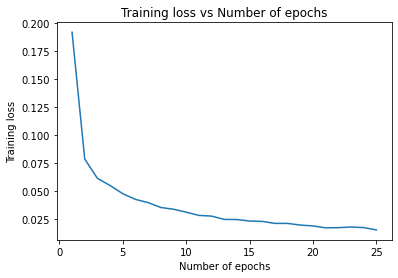

In [135]:
plt.plot(np.linspace(1, 25, 25).astype(int), train_loss_values)
plt.xlabel('Number of epochs')
plt.ylabel('Training loss')
plt.title('Training loss vs Number of epochs')

Text(0.5, 1.0, 'Training accuracy vs Number of epochs')

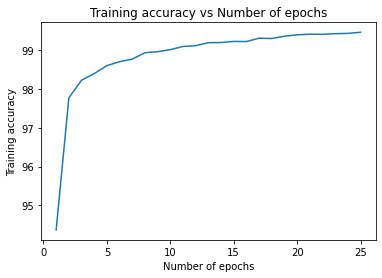

In [136]:
plt.plot(np.linspace(1, 25, 25).astype(int), train_accuracy_values)
plt.xlabel('Number of epochs')
plt.ylabel('Training accuracy')
plt.title('Training accuracy vs Number of epochs')

Text(0.5, 1.0, 'Test loss vs Number of epochs')

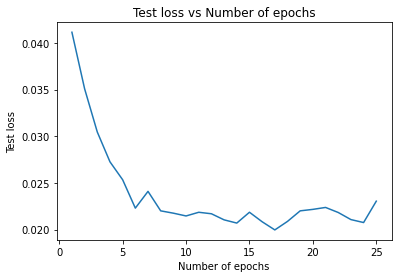

In [137]:
plt.plot(np.linspace(1, 25, 25).astype(int), test_loss_values)
plt.xlabel('Number of epochs')
plt.ylabel('Test loss')
plt.title('Test loss vs Number of epochs')

Text(0.5, 1.0, 'Test accuracy vs Number of epochs')

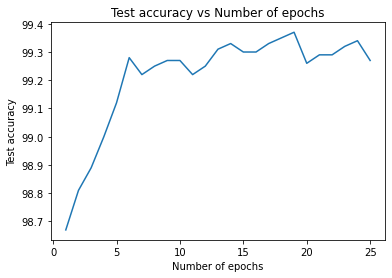

In [138]:
plt.plot(np.linspace(1, 25, 25).astype(int), test_accuracy_values)
plt.xlabel('Number of epochs')
plt.ylabel('Test accuracy')
plt.title('Test accuracy vs Number of epochs')

Time taken - 481.31 seconds <br/>
Train loss - 0.0137 <br/>
Test average loss - 0.0230 <br/> 
Test accuracy - 9927/10000 (99%) <br/>
Adagrad optimizer (99%) performed better than Adam optimizer (97%). Training loss graph has much less spikes in case of Adagrad as compared to Adam. This possibly is due to previous momentum applied in Adam which is not helping in this case and is causing it to meander a lot.

### Question 7

Initialize the `Conv2d` layers in the network defined in Question-1 `(Net)` with all ones (both weights and bias). Train the network with Adam optimizer and report the final test accuracy. Is there any difference in the performance? If yes, what do you think is the reason? 

In [139]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        #### YOUR CODE STARTS HERE ####
        # define a conv layer with output channels as 16, kernel size of 3 and stride of 1
        self.conv1 = nn.Conv2d(1, 16, 3, stride=1)
        self.conv1.weight.data.fill_(1)
        self.conv1.bias.data.fill_(1)

        # define a conv layer with output channels as 32, kernel size of 3 and stride of 1
        self.conv2 = nn.Conv2d(16, 32, 3, stride=1)
        self.conv2.weight.data.fill_(1)
        self.conv2.bias.data.fill_(1)

        # define a conv layer with output channels as 64, kernel size of 3 and stride of 1
        self.conv3 = nn.Conv2d(32, 64, 3, stride=1)
        self.conv3.weight.data.fill_(1)
        self.conv3.bias.data.fill_(1)

        # define a max pooling layer with kernel size 2
        self.pool = nn.MaxPool2d(2)
        # define dropout layer with a probability of 0.25
        self.dropout = nn.Dropout2d(p=0.25)
        # define dropout layer with a probability of 0.5
        self.dropout1 = nn.Dropout2d(p=0.5)
        # define a linear(dense) layer with 128 output features
        self.fc1 = nn.Linear(64*11*11, 128)
        # define a linear(dense) layer with output features corresponding to the number of classes in the dataset
        self.fc2 = nn.Linear(128, 10)

        #### YOUR CODE ENDS HERE ####

    def forward(self, x):
        # Use the layers defined above in a sequential way (folow the same as the layer definitions above) and 
        # write the forward pass, after each of conv1, conv2, conv3 and fc1 use a relu activation. 
        # use the first dropout after maxpool and the other one before you final FC layer
        #### YOUR CODE STARTS HERE ####
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = self.dropout(self.pool(F.relu(self.conv3(out))))
        out = torch.flatten(out, 1)
        out = F.relu(self.fc1(out))
        out = self.fc2(self.dropout1(out))
        #### YOUR CODE ENDS HERE ####
        output = F.log_softmax(out, dim=1)
        return output

In [140]:
start_time = time.time()

model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
train_loss_values = []
test_loss_values = []
train_accuracy_values = []
test_accuracy_values = []
for epoch in range(25):
    train_loss, train_accuracy = train(model, device, train_dataloader, optimizer, epoch)
    train_loss_values.append(train_loss)
    train_accuracy_values.append(train_accuracy)
    
    test_loss, test_accuracy = test(model, device, test_dataloader)
    test_loss_values.append(test_loss)
    test_accuracy_values.append(test_accuracy)

end_time = time.time()
print(end_time-start_time)

Train Epoch: 0 [0/60000 (0%)]	Loss: 176774.875000
Train Epoch: 0 [640/60000 (1%)]	Loss: 35827.753906
Train Epoch: 0 [1280/60000 (2%)]	Loss: 2.313927
Train Epoch: 0 [1920/60000 (3%)]	Loss: 2.303545
Train Epoch: 0 [2560/60000 (4%)]	Loss: 2.304146
Train Epoch: 0 [3200/60000 (5%)]	Loss: 2.296674
Train Epoch: 0 [3840/60000 (6%)]	Loss: 2.309623
Train Epoch: 0 [4480/60000 (7%)]	Loss: 2.303628
Train Epoch: 0 [5120/60000 (9%)]	Loss: 2.323938
Train Epoch: 0 [5760/60000 (10%)]	Loss: 2.301755
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.295164
Train Epoch: 0 [7040/60000 (12%)]	Loss: 2.294185
Train Epoch: 0 [7680/60000 (13%)]	Loss: 2.306315
Train Epoch: 0 [8320/60000 (14%)]	Loss: 2.301967
Train Epoch: 0 [8960/60000 (15%)]	Loss: 2.289200
Train Epoch: 0 [9600/60000 (16%)]	Loss: 2.307124
Train Epoch: 0 [10240/60000 (17%)]	Loss: 2.311517
Train Epoch: 0 [10880/60000 (18%)]	Loss: 2.314261
Train Epoch: 0 [11520/60000 (19%)]	Loss: 2.312578
Train Epoch: 0 [12160/60000 (20%)]	Loss: 2.300951
Train Epoch: 0 [1280

Text(0.5, 1.0, 'Training loss vs Number of epochs')

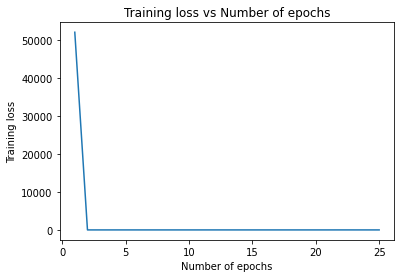

In [141]:
plt.plot(np.linspace(1, 25, 25).astype(int), train_loss_values)
plt.xlabel('Number of epochs')
plt.ylabel('Training loss')
plt.title('Training loss vs Number of epochs')

Text(0.5, 1.0, 'Training accuracy vs Number of epochs')

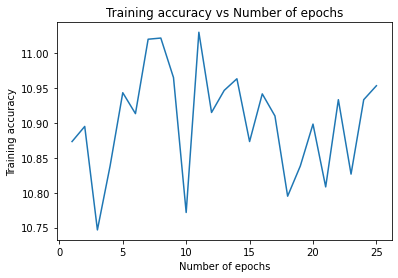

In [142]:
plt.plot(np.linspace(1, 25, 25).astype(int), train_accuracy_values)
plt.xlabel('Number of epochs')
plt.ylabel('Training accuracy')
plt.title('Training accuracy vs Number of epochs')

Text(0.5, 1.0, 'Test loss vs Number of epochs')

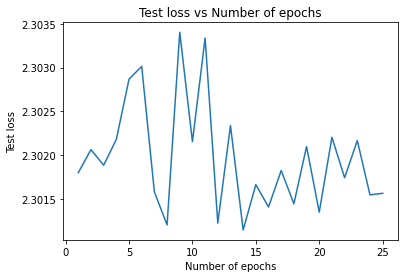

In [143]:
plt.plot(np.linspace(1, 25, 25).astype(int), test_loss_values)
plt.xlabel('Number of epochs')
plt.ylabel('Test loss')
plt.title('Test loss vs Number of epochs')

Text(0.5, 1.0, 'Test accuracy vs Number of epochs')

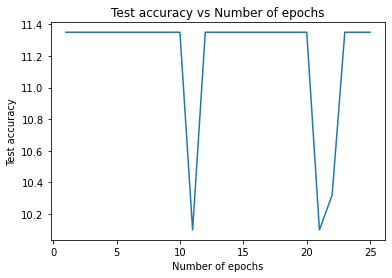

In [144]:
plt.plot(np.linspace(1, 25, 25).astype(int), test_accuracy_values)
plt.xlabel('Number of epochs')
plt.ylabel('Test accuracy')
plt.title('Test accuracy vs Number of epochs')

Time taken - 512.47 seconds <br/>
Train loss - 2.3026 <br/>
Test average loss - 2.3016 <br/> 
Test accuracy - 1135/10000 (11%) <br/>
The accuracy has drastically reduced to 11% due to unit weight and bias initialization of convolutional layers. Since all weights are initialized to one, gradients remain same and thus weights' values arriving at different neurons in a layer remain same and thus model learning is meager. 

### Question 8

Initialize the network defined in Question-1 `(Net)` with Xavier's initialization ([torch.nn.init.xavier_normal](https://pytorch.org/docs/stable/nn.init.html))(for bias use zero). Train the network with Adam optimizer and report the final test accuracy.

In [145]:
def init_xavier_weights_bias(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
      torch.nn.init.xavier_normal(m.weight)
      m.bias.data.fill_(0)

In [146]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        #### YOUR CODE STARTS HERE ####
        # define a conv layer with output channels as 16, kernel size of 3 and stride of 1
        self.conv1 = nn.Conv2d(1, 16, 3, stride=1)

        # define a conv layer with output channels as 32, kernel size of 3 and stride of 1
        self.conv2 = nn.Conv2d(16, 32, 3, stride=1)

        # define a conv layer with output channels as 64, kernel size of 3 and stride of 1
        self.conv3 = nn.Conv2d(32, 64, 3, stride=1)

        # define a max pooling layer with kernel size 2
        self.pool = nn.MaxPool2d(2)
        # define dropout layer with a probability of 0.25
        self.dropout = nn.Dropout2d(p=0.25)
        # define dropout layer with a probability of 0.5
        self.dropout1 = nn.Dropout2d(p=0.5)
        # define a linear(dense) layer with 128 output features
        self.fc1 = nn.Linear(64*11*11, 128)
        # define a linear(dense) layer with output features corresponding to the number of classes in the dataset
        self.fc2 = nn.Linear(128, 10)

        #### YOUR CODE ENDS HERE ####

    def forward(self, x):
        # Use the layers defined above in a sequential way (folow the same as the layer definitions above) and 
        # write the forward pass, after each of conv1, conv2, conv3 and fc1 use a relu activation. 
        # use the first dropout after maxpool and the other one before you final FC layer
        #### YOUR CODE STARTS HERE ####
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = self.dropout(self.pool(F.relu(self.conv3(out))))
        out = torch.flatten(out, 1)
        out = F.relu(self.fc1(out))
        out = self.fc2(self.dropout1(out))

        # out = torch.sigmoid(self.conv1(x))
        # out = torch.sigmoid(self.conv2(out))
        # out = self.dropout(self.pool(torch.sigmoid(self.conv3(out))))
        # out = torch.flatten(out, 1)
        # out = torch.sigmoid(self.fc1(out))
        # out = self.fc2(self.dropout1(out))
        #### YOUR CODE ENDS HERE ####
        output = F.log_softmax(out, dim=1)
        return output

In [147]:
start_time = time.time()

model = Net().to(device)
init_xavier_weights_bias(model)
optimizer = optim.Adam(model.parameters(), lr=0.01)
train_loss_values = []
test_loss_values = []
train_accuracy_values = []
test_accuracy_values = []
for epoch in range(25):
    train_loss, train_accuracy = train(model, device, train_dataloader, optimizer, epoch)
    train_loss_values.append(train_loss)
    train_accuracy_values.append(train_accuracy)
    
    test_loss, test_accuracy = test(model, device, test_dataloader)
    test_loss_values.append(test_loss)
    test_accuracy_values.append(test_accuracy)

end_time = time.time()
print(end_time-start_time)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.310441
Train Epoch: 0 [640/60000 (1%)]	Loss: 1.330527
Train Epoch: 0 [1280/60000 (2%)]	Loss: 0.546078
Train Epoch: 0 [1920/60000 (3%)]	Loss: 0.668824
Train Epoch: 0 [2560/60000 (4%)]	Loss: 0.571172
Train Epoch: 0 [3200/60000 (5%)]	Loss: 0.599249
Train Epoch: 0 [3840/60000 (6%)]	Loss: 0.146463
Train Epoch: 0 [4480/60000 (7%)]	Loss: 0.233468
Train Epoch: 0 [5120/60000 (9%)]	Loss: 0.219581
Train Epoch: 0 [5760/60000 (10%)]	Loss: 0.330887
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.545337
Train Epoch: 0 [7040/60000 (12%)]	Loss: 0.439097
Train Epoch: 0 [7680/60000 (13%)]	Loss: 0.426487
Train Epoch: 0 [8320/60000 (14%)]	Loss: 0.248169
Train Epoch: 0 [8960/60000 (15%)]	Loss: 0.380742
Train Epoch: 0 [9600/60000 (16%)]	Loss: 0.426889
Train Epoch: 0 [10240/60000 (17%)]	Loss: 0.493977
Train Epoch: 0 [10880/60000 (18%)]	Loss: 0.032379
Train Epoch: 0 [11520/60000 (19%)]	Loss: 0.543739
Train Epoch: 0 [12160/60000 (20%)]	Loss: 0.325616
Train Epoch: 0 [12800/60000 (

Text(0.5, 1.0, 'Training loss vs Number of epochs')

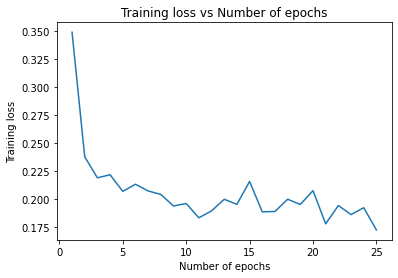

In [148]:
plt.plot(np.linspace(1, 25, 25).astype(int), train_loss_values)
plt.xlabel('Number of epochs')
plt.ylabel('Training loss')
plt.title('Training loss vs Number of epochs')

Text(0.5, 1.0, 'Training accuracy vs Number of epochs')

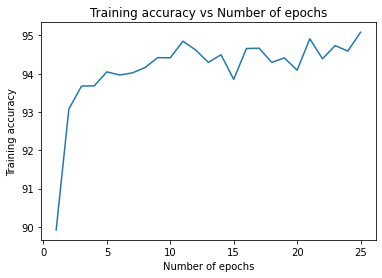

In [149]:
plt.plot(np.linspace(1, 25, 25).astype(int), train_accuracy_values)
plt.xlabel('Number of epochs')
plt.ylabel('Training accuracy')
plt.title('Training accuracy vs Number of epochs')

Text(0.5, 1.0, 'Test loss vs Number of epochs')

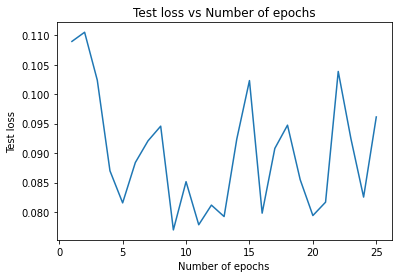

In [150]:
plt.plot(np.linspace(1, 25, 25).astype(int), test_loss_values)
plt.xlabel('Number of epochs')
plt.ylabel('Test loss')
plt.title('Test loss vs Number of epochs')

Text(0.5, 1.0, 'Test accuracy vs Number of epochs')

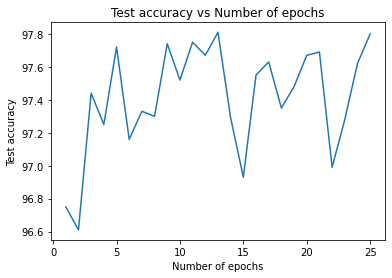

In [151]:
plt.plot(np.linspace(1, 25, 25).astype(int), test_accuracy_values)
plt.xlabel('Number of epochs')
plt.ylabel('Test accuracy')
plt.title('Test accuracy vs Number of epochs')

Time taken - 512.65 seconds <br/>
Train loss - 0.306729 <br/>
Test average loss -  0.0961 <br/> 
Test accuracy - 9780/10000 (98%) <br/>
Accuracy is increased to 98% due to xavier initializtion.


### Question 9

Add three batch-norm layers to the network defined in `Question-1` and report the final test accuracy. How does batch-norm help? 

In [152]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        #### YOUR CODE STARTS HERE ####
        # define a conv layer with output channels as 16, kernel size of 3 and stride of 1
        self.conv1 = nn.Conv2d(1, 16, 3, stride=1)
        self.conv1_batch_norm = nn.BatchNorm2d(16)

        # define a conv layer with output channels as 32, kernel size of 3 and stride of 1
        self.conv2 = nn.Conv2d(16, 32, 3, stride=1)
        self.conv2_batch_norm = nn.BatchNorm2d(32)

        # define a conv layer with output channels as 64, kernel size of 3 and stride of 1
        self.conv3 = nn.Conv2d(32, 64, 3, stride=1)
        self.conv3_batch_norm = nn.BatchNorm2d(64)

        # define a max pooling layer with kernel size 2
        self.pool = nn.MaxPool2d(2)
        # define dropout layer with a probability of 0.25
        self.dropout = nn.Dropout2d(p=0.25)
        # define dropout layer with a probability of 0.5
        self.dropout1 = nn.Dropout2d(p=0.5)
        # define a linear(dense) layer with 128 output features
        self.fc1 = nn.Linear(64*11*11, 128)
        # define a linear(dense) layer with output features corresponding to the number of classes in the dataset
        self.fc2 = nn.Linear(128, 10)

        #### YOUR CODE ENDS HERE ####

    def forward(self, x):
        # Use the layers defined above in a sequential way (folow the same as the layer definitions above) and 
        # write the forward pass, after each of conv1, conv2, conv3 and fc1 use a relu activation. 
        # use the first dropout after maxpool and the other one before you final FC layer
        #### YOUR CODE STARTS HERE ####
        out = F.relu(self.conv1_batch_norm(self.conv1(x)))
        out = F.relu(self.conv2_batch_norm(self.conv2(out)))
        out = self.dropout(self.pool(F.relu(self.conv3_batch_norm(self.conv3(out)))))
        out = torch.flatten(out, 1)
        out = F.relu(self.fc1(out))
        out = self.fc2(self.dropout1(out))
        #### YOUR CODE ENDS HERE ####
        output = F.log_softmax(out, dim=1)
        return output

In [153]:
start_time = time.time()

model = Net().to(device)
init_xavier_weights_bias(model)
optimizer = optim.Adam(model.parameters(), lr=0.01)
train_loss_values = []
test_loss_values = []
train_accuracy_values = []
test_accuracy_values = []
for epoch in range(25):
    train_loss, train_accuracy = train(model, device, train_dataloader, optimizer, epoch)
    train_loss_values.append(train_loss)
    train_accuracy_values.append(train_accuracy)
    
    test_loss, test_accuracy = test(model, device, test_dataloader)
    test_loss_values.append(test_loss)
    test_accuracy_values.append(test_accuracy)

end_time = time.time()
print(end_time-start_time)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.400640
Train Epoch: 0 [640/60000 (1%)]	Loss: 1.928152
Train Epoch: 0 [1280/60000 (2%)]	Loss: 1.832254
Train Epoch: 0 [1920/60000 (3%)]	Loss: 1.538858
Train Epoch: 0 [2560/60000 (4%)]	Loss: 1.403220
Train Epoch: 0 [3200/60000 (5%)]	Loss: 1.168024
Train Epoch: 0 [3840/60000 (6%)]	Loss: 1.282658
Train Epoch: 0 [4480/60000 (7%)]	Loss: 0.917681
Train Epoch: 0 [5120/60000 (9%)]	Loss: 1.546364
Train Epoch: 0 [5760/60000 (10%)]	Loss: 1.041747
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.276912
Train Epoch: 0 [7040/60000 (12%)]	Loss: 1.549768
Train Epoch: 0 [7680/60000 (13%)]	Loss: 1.213875
Train Epoch: 0 [8320/60000 (14%)]	Loss: 1.076834
Train Epoch: 0 [8960/60000 (15%)]	Loss: 0.883009
Train Epoch: 0 [9600/60000 (16%)]	Loss: 0.863959
Train Epoch: 0 [10240/60000 (17%)]	Loss: 0.838152
Train Epoch: 0 [10880/60000 (18%)]	Loss: 0.643323
Train Epoch: 0 [11520/60000 (19%)]	Loss: 0.848495
Train Epoch: 0 [12160/60000 (20%)]	Loss: 1.232268
Train Epoch: 0 [12800/60000 (

Text(0.5, 1.0, 'Training loss vs Number of epochs')

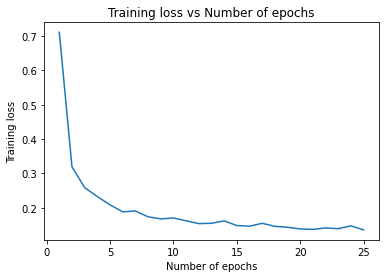

In [154]:
plt.plot(np.linspace(1, 25, 25).astype(int), train_loss_values)
plt.xlabel('Number of epochs')
plt.ylabel('Training loss')
plt.title('Training loss vs Number of epochs')

Text(0.5, 1.0, 'Training accuracy vs Number of epochs')

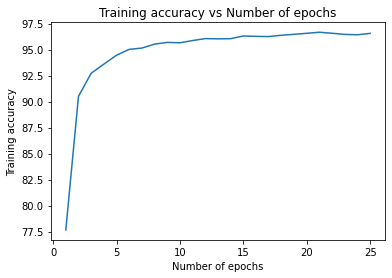

In [155]:
plt.plot(np.linspace(1, 25, 25).astype(int), train_accuracy_values)
plt.xlabel('Number of epochs')
plt.ylabel('Training accuracy')
plt.title('Training accuracy vs Number of epochs')

Text(0.5, 1.0, 'Test loss vs Number of epochs')

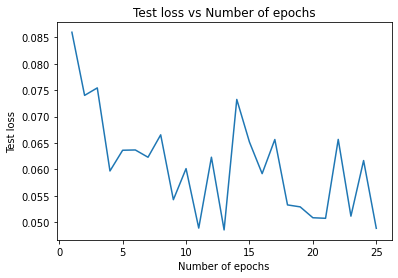

In [156]:
plt.plot(np.linspace(1, 25, 25).astype(int), test_loss_values)
plt.xlabel('Number of epochs')
plt.ylabel('Test loss')
plt.title('Test loss vs Number of epochs')

Text(0.5, 1.0, 'Test accuracy vs Number of epochs')

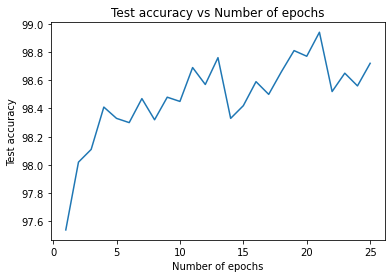

In [157]:
plt.plot(np.linspace(1, 25, 25).astype(int), test_accuracy_values)
plt.xlabel('Number of epochs')
plt.ylabel('Test accuracy')
plt.title('Test accuracy vs Number of epochs')

Time taken - 560.70 seconds <br/>
Train loss - 0.1379 <br/>
Test average loss - 0.0488 <br/> 
Test accuracy - 9872/10000 (99%) <br/>
Test accuracy is increased to 99% due to batch normaliztion. This is due to normaliztion of inputs at each layer and reduces internal covariate shift and thus reduce dependence of gradients on the scale of params. It also accelerates learning as it achieves accuracy of 98% in less than 5 epochs.

# Part-3 (Optional)

This section is un-graded and purely for practice. 

Main focus of this part is to help you flex the deep learning muscles built in the above part. You should build a network on the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This dataset is similar to MNIST but unlike MNIST, the images are colored and more complex. 

As of writing this, the state-of-the-art(SoTA) performance on this dataset is 98.98%. You can try to start with the simple network we defined above for the MNSIT dataset(with some modification for dealing with different sized colored images unlike MNIST). But to achive the SoTA performance you need to do a lot of hackery. These are list of few things, we would encourage you to try: 

- Use data augmentation wisely. Read and understand how to perform the augmentations listed below. 
    * RandomFlips, Color Jittering
    * Cutout, Cutmix
    * Mixup
    * Auto-augment

- Try to increase the image size using standard image interpolation techniques. Try using tricks like Progressive resizing of images and see if it helps. 

- After certain number of layers, adding more layer might not be of much help, run experiments on SVHN and see if you observe this. 

- To understand the difficulties in training deeper networks read this paper: [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)

- To improve the performance on SVHN, try using architectures like [ResNet](https://arxiv.org/abs/1512.03385), [DesnseNet](https://arxiv.org/abs/1608.06993) or [EfficientNet](https://arxiv.org/abs/1905.11946). Most of these architectures are available by default in PyTorch.
